
## **Summary of class/function for the tibia tracking**

### Summarize the functions for the tibia tracking and calculating the tibia angle for each imaging frame.

* based on original scripts and versions from:



> * *20220425_select_background_threshold_track_tibia_arculum_tracking_flies_20220303_1*
* *20220426_tibia_angle_convert_unwrap_align_claw+cap_tracking_flies.ipynb*
> * *20220426_Calculate_and_Plot_femur_tibia_angle_for_imaging_frame_claw+cap_tracking.ipynb*



* may combine as a class and make .yaml later on.

* initially put together all the relevant functions, make sure it works.

* some needs to be tested on a Desktop (rather than online).

### Connect to the google drive

In [1]:
#link to the google drive. Need to follow the authorization instructions.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#import the necessary packages.
import numpy as np
import os
import fnmatch
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.ndimage import gaussian_filter1d
import pickle
from skimage.segmentation import watershed
from skimage.measure import regionprops_table, label
import cv2
import seaborn as sb
import IPython.display as Disp
from ipywidgets import widgets
from scipy.stats import circmean
from skimage.feature import peak_local_max

#Class and functions for selecting an ROI
class ROI_select():
    %matplotlib notebook 


    def __init__(self,im):
        self.im = im
        self.selected_points = []
        self.fig,ax = plt.subplots()
        self.img = ax.imshow(self.im.copy())
        self.ka = self.fig.canvas.mpl_connect('button_press_event', self.onclick)
        disconnect_button = widgets.Button(description="Disconnect mpl")
        Disp.display(disconnect_button)
        disconnect_button.on_click(self.disconnect_mpl)


        
    def poly_img(self,img,pts):
        pts = np.array(pts, np.int32)
        pts = pts.reshape((-1,1,2))
        cv2.polylines(img,[pts],True,(255,255,255),1)
        return img

    def onclick(self, event):
    #display(str(event))
        self.selected_points.append([event.xdata,event.ydata])
        if len(self.selected_points)>1:
            self.fig
            self.img.set_data(self.poly_img(self.im.copy(),self.selected_points))
    def disconnect_mpl(self,_):
        self.fig.canvas.mpl_disconnect(self.ka)

#a function for capturing a specified frame from the video for the tibia tracking ROI
#frame_number1 = 0, frame_number2 = 6500
def get_video_frame(video_file_name, frame_number1, frame_number2):
  
  ### Load the frames from the video
  cap = cv2.VideoCapture(video_file_name)

  #Check if the video was opened
  if (cap.isOpened()==False):
    print("Error opening video file")

  #Set to the specified frame
  cap.set(1,frame_number1)

  #get the frame
  ret,frame1=cap.read()

  #Set to the specified frame
  cap.set(1,frame_number2)

  #get the frame
  ret,frame2=cap.read()

  cap.release()

  return {'first_frame':frame1, 'second_frame':frame2}

#A function to combine and subtract the background.
def combine_and_subtract_background(background1, background2, frame1, frame2):
  arr1 = np.array([background1.selected_points],'int')
  mask1 = cv2.fillPoly(np.zeros((frame1.shape[0],frame1.shape[1]),np.uint8),arr1,[1,1,1])

  arr2 = np.array([background2.selected_points],'int')
  mask2 = cv2.fillPoly(np.zeros(mask1.shape,np.uint8),arr2,[1,1,1])

  #frame1, frame2, and background pixels is 3D. mask is 2D.

  #make background all zero first
  background_pixels=np.zeros(frame1.shape,dtype=np.int16)
  #For the pixels selected in the first frame, change those pixels values to those of the frame1
  background_pixels[mask1==1]=frame1[mask1==1]
  #For the pixels selected in the second frame, change those pixels values to those of the frame2
  background_pixels[mask2==1]=frame2[mask2==1]
  plt.imshow(background_pixels)
  plt.axis('off')

  #Combin mask 1 and mask 2
  #make background all zero first
  combined_mask=np.zeros(mask1.shape,dtype=np.int16)
  combined_mask[mask1==1]=1
  combined_mask[mask2==1]=1
  fig,ax=plt.subplots(1,1,figsize = (7,7))
  ax.imshow(combined_mask)

  ### Show frame1 after the background subtraction

  ### frame1 has 3 dimensions, so just use the 1st part
  frame1_image=frame1[:,:,0]
  #Chose just the ROI
  ROI_image=np.multiply(frame1_image,combined_mask)
  #Subtract the background.
  ROI_image_sub_background=ROI_image-background_pixels[:,:,0]

  ### Show frame2 after the background subtraction

  ### frame2 has 3 dimensions, so just use the 1st part
  frame2_image=frame2[:,:,0]
  #Chose just the ROI
  ROI_image2=np.multiply(frame2_image,combined_mask)
  #Subtract the background. Background still has 3D
  ROI_image_sub_background2=ROI_image2-background_pixels[:,:,0]

  fig, ax = plt.subplots(1, 2,figsize=(4.5,7))
  ax[0].imshow(ROI_image_sub_background)
  ax[1].imshow(ROI_image_sub_background2)
  ax[0].xaxis.set_ticks([])
  ax[0].yaxis.set_ticks([])
  ax[1].xaxis.set_ticks([])
  ax[1].yaxis.set_ticks([])

  return {'mask':combined_mask, 'background':background_pixels}

#A function for checking the threshold for a given frame.
def check_tibia_threshold(video_file, frame_number, combined_mask, background_pixels, threshold):
    ### Load the frames from the video
    cap = cv2.VideoCapture(video_file)

    #Check if the video was opened
    if (cap.isOpened()==False):
        print("Error opening video file")
   
    #Set to the specified frame
    cap.set(1,frame_number)

    #get the frame
    ret,frame=cap.read()

    cap.release()
    
    
    ### frame has 3 dimensions, so just use the 1st part
    frame_image=frame[:,:,0]
    #Chose just the ROI: combined_mask is already defined above
    ROI_image=np.multiply(frame_image,combined_mask)
    #Subtract the background: background_pixels is already defined above
    ROI_image_sub_background=ROI_image-background_pixels[:,:,0]
    #Find pixels above the threshold
    Selected_pixels=ROI_image_sub_background >= threshold
    #Change the Selected_pixels to int (from logical)
    Selected_pixels=Selected_pixels.astype(np.int8)
    #Get the orientation of the pixels
    props_table=regionprops_table(Selected_pixels,properties=['orientation'])
    tibia_angle=props_table['orientation']    
    
    plt.imshow(Selected_pixels)
    
    print((tibia_angle*360)/(2*np.pi))
    return {'threshold':threshold, 'frame_number':frame_number}


#A funtion for saving the mask, background, and threshold
def save_mask_background_thresholds(video_file_name, mask_background, threshold_frame):
    #Save the combined_mask, background_pixels, and threshold
    outfile_name=(video_file_name[0:-4]+"_mask_background_threshold")
    combined_mask = mask_background['mask']
    background_pixels = mask_background['background']
    threshold = threshold_frame['threshold']
    frame_number = threshold_frame['frame_number']
    with open(outfile_name,'wb') as f:
      pickle.dump([combined_mask,background_pixels, threshold, frame_number], f)
    print(outfile_name)

'''
A new version of a function that tracks the tibia

* now specified threshold will be used for the first frame and it is used to determine the number of pixels that will be used to detect the tibia in all frames (use N brightest pixels)

* for every frame we will sort the pixel intensities and determine the threshold.

* then we label each contiguous group of pixels as one area and use only the orientation of the biggest area.

* we can convert the angle by flipping them at different point if necessary (later on).

'''
def track_tibia_angle_Nbrightest_maxArea(video_file, mask_background_threshold_file):
    #read in the mask, background, threshold, and frame number.
    with open(mask_background_threshold_file,'rb') as f:
      [combined_mask,background_pixels, threshold, frame_number] = pickle.load(f)
    
    ### First get one frame and determine how many pixels to use
    ### Load the frames from the video
    cap = cv2.VideoCapture(video_file)

    #Check if the video was opened
    if (cap.isOpened()==False):
        print("Error opening video file")
   
    #Set to the specified frame
    cap.set(1,frame_number)

    #get the frame
    ret,frame=cap.read()

    cap.release()
    
    #frame has 3 dimensions, so just use the 1st part
    frame_image=frame[:,:,0]
    #Chose just the ROI: combined_mask is already defined above
    ROI_image=np.multiply(frame_image,combined_mask)
    #Subtract the background: background_pixels is already defined above
    ROI_image_sub_background=ROI_image-background_pixels[:,:,0]
    #Sort the pixel intensities
    sorted_array=np.sort(ROI_image_sub_background, axis=None)
    #Find the index for the specified threshold
    difference_from_threshold=sorted_array-threshold
    threshold_index=np.argmin(np.abs(difference_from_threshold))
    print(threshold_index)
    
    
    ### Load the frames from the video
    cap = cv2.VideoCapture(video_file)

    #Check if the video was opened
    if (cap.isOpened()==False):
        print("Error opening video file")

    #Check how many frames we have
    max_frames=cap.get(7)
    max_frames=int(max_frames)

    #Initialize the orientation matrix.
    tibia_angle=np.zeros((max_frames,1))

    for frame_number in range(max_frames):
        #read in the frame
        ret, frame=cap.read()
    
        ### frame has 3 dimensions, so just use the 1st part
        frame_image=frame[:,:,0]
        #Chose just the ROI: combined_mask is already defined above
        ROI_image=np.multiply(frame_image,combined_mask)
        #Subtract the background: background_pixels is already defined above
        ROI_image_sub_background=ROI_image-background_pixels[:,:,0]
        
        #Find the threshold for this particular image
        sorted_array=np.sort(ROI_image_sub_background, axis=None)
        image_threshold=sorted_array[threshold_index]
        
        #Find pixels above the threshold
        Selected_pixels=ROI_image_sub_background >= image_threshold
        #Label the image into connected pixels
        label_im=label(Selected_pixels)
        #Get the area and the orientation for each labeled regions
        regions = regionprops_table(label_im,properties=['orientation','area'])
        #Find the biggest area
        areas=regions['area']
        max_index=np.nanargmax(areas)
        #Use the orientation of that region
        orientations=regions['orientation']
        tibia_angle[frame_number,0]=orientations[max_index]    
    
    cap.release()

    #plot the tibia angle
    plt.plot(tibia_angle)
    
    #return the tibia angle
    return tibia_angle

#a function for adjusting out of range angles
def adjust_out_of_range_angles(tibia_angle, threshold_angle):
  out_of_range_index=tibia_angle<=threshold_angle
  tibia_angle[out_of_range_index]=tibia_angle[out_of_range_index]+np.pi
  plt.plot(tibia_angle)
  return tibia_angle

#A function for saving the tibia angle (after range adjustment, but before conversion and offset)
def save_tibia_angles_in_range(tibia_angle, video_file_name):
  outfile_name=(video_file_name[0:-4]+"_tibia_angle")
  print(outfile_name)

  with open(outfile_name, 'wb') as f:
    pickle.dump(tibia_angle,f)


#A function for loading the tibia angle (after range adjustment, but before conversion and offset)
def load_tibia_angle_in_range(angles_file):
  print(angles_file)
  with open(angles_file, 'rb') as f:
    tibia_angle=pickle.load(f)

  plt.plot(tibia_angle)
  return tibia_angle

#A function for converting to degrees (from radian)
def convert_tibia_angle_to_deg(tibia_angle):
  converted_angle=(tibia_angle*180)/np.pi
  plt.plot(converted_angle)
  return converted_angle

#A function for flipping the orientation
def flip_tibia_angle_orientation(converted_angle):
  converted_angle_oriented=180-converted_angle
  plt.plot(converted_angle_oriented)
  return converted_angle_oriented

#A function for adjusting for the offset
def tibia_angle_adjust_offset(converted_angle_oriented, offset):
  converted_angle_oriented_adjusted=converted_angle_oriented+offset
  plt.plot(converted_angle_oriented_adjusted)
  return converted_angle_oriented_adjusted

#A function for saving the new flipped and adjusted tibia angle
def save_adjusted_tibia_angle(tibia_file, converted_angle_oriented_adjusted):
  #Save the converted_angle_oriented_adjusted
  outfile_name=(tibia_file+"_adjusted")
  with open(outfile_name,'wb') as f:
    pickle.dump(converted_angle_oriented_adjusted, f)

  print(outfile_name)

# A function for taking the circular mean of the tibia angles, ignoring NaN
def radian_circular_mean_ignoring_NaN(angle_data):
  #find angles that are not NaN of infinite.
  finite_index=np.isfinite(angle_data)
  finite_angles=angle_data[finite_index]
  new_angle_data=circmean(finite_angles, high=np.pi)

  return new_angle_data

'''
### Revised function for un-wrapping the angle and converting to the degrees
*   angle_rad_original: original femur-tibia angle for each imaging frame in radians
*   low_angle_threshold: angle (in radians) where anything lower than this is considered invalid and moved to larger angles (by adding pi). May be around 0.1 or 0.15 (we might need to adjust for the offset before this: some flies have a wrong femur angle)
* high_angle_threshold: angle (in radians) where anything above this is considered invalid and amoved to smaller angles. Should be around pi.
'''
def unwrap_and_convert_tibia_angles(angle_rad_original,low_angle_threshold, high_angle_threshold):
  #Make new np.array so we don't overwrite the original.
  angle_rad=np.array(angle_rad_original)
  
  #currently the image_femur_tibia_angle contains NaN. in the future, interpolate to take out the NaN values.
  low_angle_index=angle_rad<=low_angle_threshold
  high_angle_index=angle_rad>=high_angle_threshold
  angle_rad[low_angle_index]=angle_rad[low_angle_index]+np.pi
  angle_rad[high_angle_index]=angle_rad[high_angle_index]-np.pi

  #convert to degrees for plotting.
  angle_degrees=np.degrees(angle_rad)
  
  return angle_degrees

'''
### Revise a function for going through the frames and calculate the mean femur-tibia angle (circular mean) for each frame:
* angles_data: femur-tibia angle in radians (from previous analysis) for each camera frame
* frame_data: information to match each imaging frame to camera frames (from previous analysis).
* n_of_z: number of z-levels that each stack contains.
* offset_deg: offset angles (degrees) to add to the femur-tibia angle.
* low_wrap_threshold: angles below this (in degrees) will be automatically assumed to be larger than 180 (to de-wrap the angles). 7.5 deg?
* high_wrap_threshold: similar to above, but for high angles.

#### A function will now save the angles in degrees.
'''
#get the femur-tibia angle for each averaged imaging frame (image stack of 4)
#we should average from the camera image closest to the 1st one till one before
#the camera image closest to the 5th one. (for the first image)

def average_tibia_angle_for_each_image(angles_data, frame_data, n_of_z, offset_deg, low_wrap_threshold, high_wrap_threshold):
    
    #Check the number of data points
    number_of_data=frame_data.shape[0]
    
    #Get the index for the first image in each stack
    first_image_index=np.arange(0,number_of_data,n_of_z)
    camera_frame_for_image=frame_data[first_image_index]
    
    #Number of frames in the image data
    total_frames = camera_frame_for_image.shape[0]
    #add one more data point, so we can calculate the average angle with for loop.
    #here we assume that the index will increase by the same amount.
    #camera_frame_for_image=np.append(camera_frame_for_image,camera_frame_for_image[total_frames-1]+(camera_frame_for_image[total_frames-1]-camera_frame_for_image[total_frames-2]))

    #initialize some data array
    angle_for_each_image=np.zeros((total_frames,1))
    
    #Go through all the frames.
    for frame_number in range(total_frames-1):
        #
        #Get the averae angle for each image. Each image is composed of a z-stack.
        angle_for_each_image[frame_number,0]=radian_circular_mean_ignoring_NaN(angles_data[int(camera_frame_for_image[frame_number]):int(camera_frame_for_image[frame_number+1])])

    #Add the offset in radians.
    offset_radians=np.radians(offset_deg)
    angle_for_each_image=angle_for_each_image+offset_radians

    #Un-wrap if smaller than the wrap_threshold.
    low_wrap_threshold_radians=np.radians(low_wrap_threshold)
    high_wrap_threshold_radians=np.radians(high_wrap_threshold)
    angle_for_each_image_deg=unwrap_and_convert_tibia_angles(angle_for_each_image,low_wrap_threshold_radians, high_wrap_threshold_radians)

        
    return angle_for_each_image_deg

#A function for loading the necessary data files and calculating the tibia angle for each imaging frame.
def load_angle_framedata_calculate_angle_for_image(frame_file, angle_file, n_of_z, offset_deg, low_wrap_threshold, high_wrap_threshold):
  #loading the frames data file
  with open(frame_file,"rb") as f:
    [image_in_camera_index,camera_minus_image_index] = pickle.load(f)

  #Index for the angles file: data is already converted to degrees, unwrapped, and adjusted for offset.
  #We need to put it back to radians.
  #load the adjusted femur-tibia angle file
  with open(angle_file, "rb") as f:
    tibia_angle_degrees=pickle.load(f)            

  #Run and get the tibia_angle_for_each_image

  #First need to convert from degrees to radians.
  tibia_angle_radians=np.deg2rad(tibia_angle_degrees)

  image_femur_tibia_angle=average_tibia_angle_for_each_image(tibia_angle_radians,image_in_camera_index, n_of_z, offset_deg, low_wrap_threshold, high_wrap_threshold)
    
  #Save in a pickle file
  outfile_name=(angle_file+"_image")
    
  with open(outfile_name,"wb") as f:
    pickle.dump([image_femur_tibia_angle], f)

  #plot the figure (without the un-wrap)
  plt.figure(figsize=(10,5))
  plt.plot(image_femur_tibia_angle)
  plt.ylim([0, 180])
  sb.despine()

### To access the shared data to run the analyses online on google colab (excluding the interactive ROI/cell selection that needs to be done locally)
* go find "Tuthill Lab Shared/shared_data/2022_Biomechanics" folder in the google drive.
* right click on the folder and select "add shortcut".
* select the location on "My Drive" to place the shortcut.
* change the path below to the path to the shortcut.

### We have an example from 20220301-1:


In [4]:
#Get the file path to the video data.
VideoFilesPath=[]
#Path for the image files
path = '/content/drive/MyDrive/Analysis/2022_Biomechanics/tibia_tracking/'

#Go through all the files in a directory
for file_name in os.listdir(path):
    if fnmatch.fnmatch(file_name,'*.mp4'):
        VideoFilesPath.append(os.path.join(path,file_name))
        
VideoFilesPathSorted=sorted(VideoFilesPath)

#Print to make sure
for f in VideoFilesPathSorted:
    print(f)


/content/drive/MyDrive/Analysis/2022_Biomechanics/tibia_tracking/Copy of Copy of Copy of Basler_acA800-510um__22190106__20220301_121218979.mp4


### Get the frames from a video (flexed and extended, two positions)

In [ ]:
trial_number = 0
result_frames = get_video_frame(VideoFilesPathSorted[trial_number], 0, 6500)


### Select background for the tibia extension

* won't work online; check later on desktop.

select the first background


Button(description='Disconnect mpl', style=ButtonStyle())

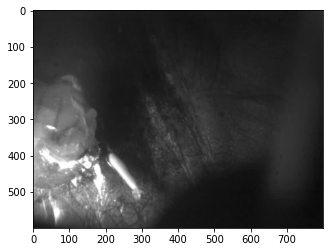

In [ ]:
#only to show inline for now
%matplotlib inline
print('select the first background')
background1=ROI_select(result_frames['first_frame'])

### Select background for tibia flexion

select the second background


Button(description='Disconnect mpl', style=ButtonStyle())

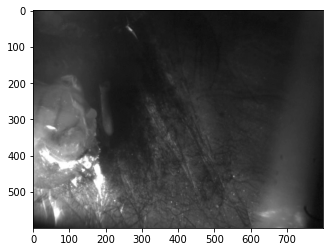

In [ ]:
print('select the second background')
background2=ROI_select(result_frames['second_frame'])

### Just for checking the script
* on desktop, we should be able to select the ROI and get the actual points.

In [ ]:
background1.selected_points=[[100,100],[100,350],[700,350],[700,100]]
background2.selected_points=[[100,350],[100,500],[700,500],[700,350]]

### Combine the backgrounds selected and subtract it from the image

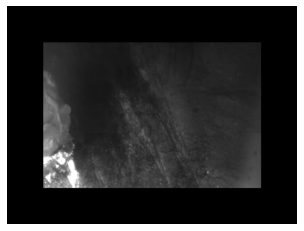

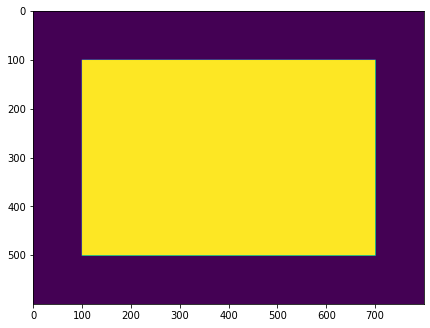

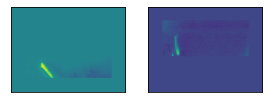

In [ ]:
%matplotlib inline
mask_and_background = combine_and_subtract_background(background1, background2, result_frames['first_frame'], result_frames['second_frame'])

### Check the correct threshold to detect the tibia

* choose the threshold that we can see the pin clearly, but not the background.

[7.02506138]


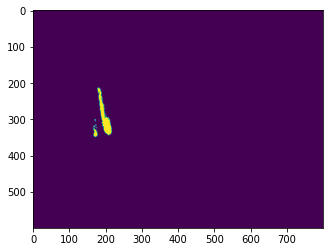

In [ ]:
%matplotlib inline
threshold_and_frame = check_tibia_threshold(VideoFilesPathSorted[0],6000,mask_and_background['mask'],mask_and_background['background'],17)

### Save the mask, background image, and threshold (these should be the same for each fly: unless we moved the prep or the camera, or we changed the lighting)

In [ ]:
save_mask_background_thresholds(VideoFilesPathSorted[trial_number],mask_and_background, threshold_and_frame)

/content/drive/MyDrive/Analysis/test/Biomechanics_test/tibia_tracking/Copy of Copy of Basler_acA800-510um__22190106__20220301_121218979_mask_background_threshold


### Track tibia angle

In [5]:
#Get the file name for the mask-backround-threshold (saved above)


#Get the file path to the video data.
mask_files_path=[]
#Path for the mask-background files


#Go through all the files in a directory
for file_name in os.listdir(path):
    if fnmatch.fnmatch(file_name,'*mask_background_threshold'):
        mask_files_path.append(os.path.join(path,file_name))
        
mask_files_path_sorted=sorted(mask_files_path)

#Print to make sure
for f in mask_files_path_sorted:
    print(f)


/content/drive/MyDrive/Analysis/2022_Biomechanics/tibia_tracking/Copy of Copy of Copy of Basler_acA800-510um__22190106__20220301_121218979_mask_background_threshold


478022


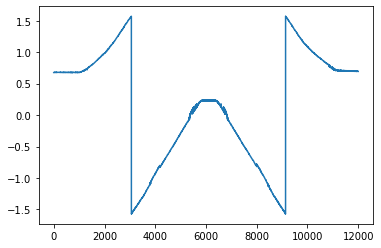

In [ ]:
trial_number = 0
%matplotlib inline
tibia_angle=track_tibia_angle_Nbrightest_maxArea(VideoFilesPathSorted[trial_number], mask_files_path_sorted[trial_number])

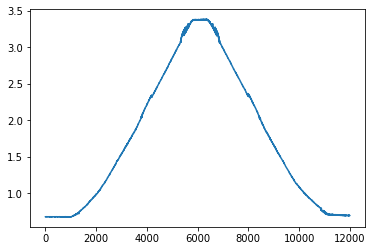

In [ ]:
%matplotlib inline
new_tibia_angle = adjust_out_of_range_angles(tibia_angle, 0.5)

### save the tibia angle

In [ ]:
trial_number = 0
save_tibia_angles_in_range(new_tibia_angle, VideoFilesPathSorted[trial_number])

/content/drive/MyDrive/Analysis/test/Biomechanics_test/tibia_tracking/Copy of Copy of Basler_acA800-510um__22190106__20220301_121218979_tibia_angle


### This section is for adjusting for the offset and converting the angles.

* continue with the same set of functions.
* change into a class?

### Load the data for the tibia angles in range



In [6]:
#Get the path for the "*_tibia_angle" files. 
#It contains both the mean and the max projection data

angles_files_path=[]


#Go through all the files in a directory
for file_name in os.listdir(path):

  if fnmatch.fnmatch(file_name,'*_tibia_angle'):
    angles_files_path.append(os.path.join(path,file_name))
        
angles_files_path_sorted=sorted(angles_files_path)

#Print to make sure
for f in angles_files_path_sorted:
    print(f)




/content/drive/MyDrive/Analysis/2022_Biomechanics/tibia_tracking/Copy of Copy of Copy of Basler_acA800-510um__22190106__20220301_121218979_tibia_angle


### Load the tibia angle file

/content/drive/MyDrive/Analysis/test/Biomechanics_test/tibia_tracking/Copy of Copy of Basler_acA800-510um__22190106__20220301_121218979_tibia_angle


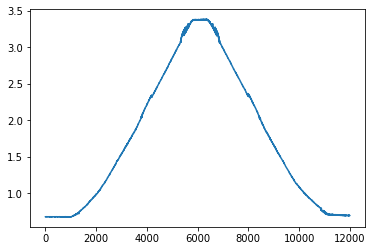

In [ ]:
%matplotlib inline
trial_number = 0
tibia_angle = load_tibia_angle_in_range(angles_files_path_sorted[trial_number])

### Convert to degrees

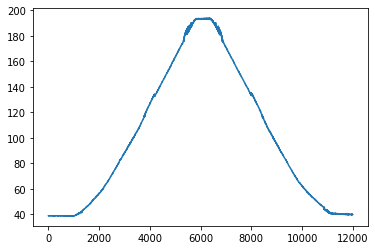

In [ ]:
%matplotlib inline
converted_angle = convert_tibia_angle_to_deg(tibia_angle)

### Get the orientaion correctly

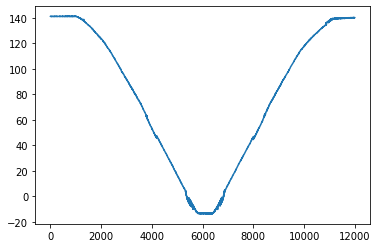

In [ ]:
%matplotlib inline
converted_angle_oriented = flip_tibia_angle_orientation(converted_angle)

### Adjust for the offset

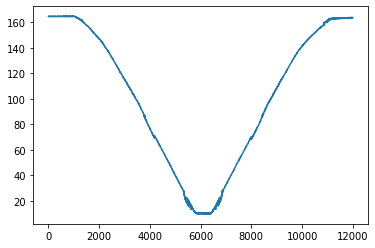

In [ ]:
%matplotlib inline
offset = 23.4
converted_angle_oriented_adjusted = tibia_angle_adjust_offset(converted_angle_oriented, offset)

### Save the newly converted and adjusted angle

In [ ]:
%matplotlib inline
save_adjusted_tibia_angle(angles_files_path[trial_number], converted_angle_oriented_adjusted)

/content/drive/MyDrive/Analysis/test/Biomechanics_test/tibia_tracking/Copy of Copy of Basler_acA800-510um__22190106__20220301_121218979_tibia_angle_adjusted


### This section for calculating the angle for each frame.

* summarize functions in the same place.
* may combine all as one or several classes; may use .yaml for some of the parameters.
* currently re-convert the radians to degrees to use the functions from before. (we may change this when we revise next time).
* need to load the frame-data from another file.

In [7]:
#Get the file path to the files containing femur-tibia angle data
angles_file_path=[]


#Go through all the files in a directory (probably includes subidirectoies as well?)
for file_name in os.listdir(path):
    if fnmatch.fnmatch(file_name,'*_tibia_angle_adjusted'):
        angles_file_path.append(os.path.join(path,file_name))
        
angles_file_path_sorted=sorted(angles_file_path)

#Print to make sure
for f in angles_file_path_sorted:
    print(f)


/content/drive/MyDrive/Analysis/2022_Biomechanics/tibia_tracking/Copy of Copy of Copy of Basler_acA800-510um__22190106__20220301_121218979_tibia_angle_adjusted


### Get the path for the files that contain frames  data

In [8]:
#Get the file path to the labels for all frames

frames_file_path=[]

#Go through all the files in a directory (probably includes subidirectoies as well?)
for file_name in os.listdir(path):
    if fnmatch.fnmatch(file_name,'*frame_data'):
        frames_file_path.append(os.path.join(path,file_name))
        
frames_file_path_sorted=sorted(frames_file_path)

#Print to make sure
for f in frames_file_path_sorted:
    print(f)


/content/drive/MyDrive/Analysis/2022_Biomechanics/tibia_tracking/Copy of Copy of Copy of 20220301T121220_20220301-73D10-Redstinger-nompA-GFP_00011frame_data


### Run for a specific file in the directory that we tracked the arculum
* we could make all into a class and keep all the parameters?

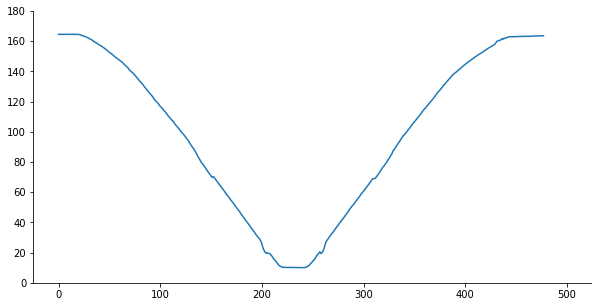

In [ ]:
%matplotlib inline
trial_number = 0
n_of_z = 7
offset_deg = 0
low_wrap_threshold = 0
high_wrap_threshold = 180
load_angle_framedata_calculate_angle_for_image(frames_file_path_sorted[trial_number], angles_file_path_sorted[trial_number], n_of_z, offset_deg, low_wrap_threshold, high_wrap_threshold)